# Example: Regional Tasmania forced by Reanalysis dataset and ERA5

**Before you begin, make sure you've downloaded and installed the package, and have set up your FRE-NC tools as outlined in the package README**

In addition, for this example you'll need a copy of the [GEBCO bathymetry](https://www.gebco.net/data_and_products/gridded_bathymetry_data/), access to the [GLORYs ocean reanalysis data](https://data.marine.copernicus.eu/product/GLOBAL_MULTIYEAR_PHY_001_030/description), and [ERA5 surface forcing for 2003](https://www.ecmwf.int/en/forecasts/dataset/ecmwf-reanalysis-v5). 

This script is designed to read in the entire global extent of ERA5 and GEBCO, so you don't need to worry about cutting it down to size. 

## What does this notebook do?
This notebook is designed to set you up with a working MOM6 regional configuration. First, try and get it running with our default Tasmania case, then you can clone the notebook and modify for your region of interest. 

Input Type | Source | Subsets required
---|---|---
Surface | [ERA5 surface forcing](https://www.ecmwf.int/en/forecasts/dataset/ecmwf-reanalysis-v5) | Data from 2003, whole globe or subset around domain
Ocean | [GLORYs reanalysis product](https://data.marine.copernicus.eu/product/GLOBAL_MULTIYEAR_PHY_001_030/description) | Snapshot from 01/01/2003 over domain, one timeseries for each rectangular boundary segment   
Bathymetry | [GEBCO](https://www.gebco.net/data_and_products/gridded_bathymetry_data/) | whole globe or subset around domain

In [2]:
import numpy as np
import xarray as xr
import os
import shutil
import regional_mom6 as rm
from pathlib.Path import Path
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/44739/status,
Dashboard: /proxy/44739/status,Workers: 4
Total threads: 16,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45817,Workers: 4
Dashboard: /proxy/44739/status,Total threads: 16
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://127.0.0.1:38687,Total threads: 4
Dashboard: /proxy/41735/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:41549,


## Step 1: Choose our domain, define workspace paths

To make sure that things are working I'd recommend starting with the default example defined below. If this runs ok, then change to a domain of your choice and hopefully it runs ok too! There's some troubleshooting you can do if not (check readme / readthedocs)

To find the lat/lon of the domain you want to test you can use <a href="https://data.marine.copernicus.eu/product/GLOBAL_MULTIYEAR_PHY_001_030/download" > this GUI </a> and copy paste below

In [4]:
expt_name = "tasmania-example-reanalysis"

## Choose your coordinates and the name of your experiment
yextent = [-48,-38.95] ## latitude
xextent = [143,150] ## longitude

daterange = ["2003-01-01 00:00:00", "2003-01-05 00:00:00"] ## 2003 is a good compimise for GLORYs and JRA forcing as they overlap. JRA ends in 2012, GLORYS starts in 1993

## Place where all your input files go 
inputdir = Path(f"YOUR_PATH/mom6_inputdirs/{expt_name}/")

## Directory where you'll run the experiment from
rundir = Path(f"YOUR_PATH/mom6_rundirs/{expt_name}/")

## Directory where fre tools are stored 
toolpath = Path("PATH_TO_COMPILED_FRE_TOOLS") ## Compiled tools needed for construction of mask tables

## Path to where your raw ocean forcing files are stored
glorys_path = Path("PATH_TO_GLORYS_DATA" )

for i in [rundir,glorys_path,inputdir]:
    if not os.path.exists(str(i)):
        os.makedirs(str(i))




## Step 2: Prepare ocean forcing data

We need to cut out our ocean forcing. The package expects an initial condition and one time-dependent segment per non-land boundary. Naming convention is "east_unprocessed" for segments and "ic_unprocessed" for the initial condition.

Data can be downloaded directly from the [Copernicus Marine data store](https://data.marine.copernicus.eu/product/GLOBAL_MULTIYEAR_PHY_001_030/download) via their GUI (once you're logged in). Unfortunately their old client `motuclient` is no longer working and they're currently in the process of replacing it. Until this is restored, and this notebook is updated with their new client, users will need to download each segment manually

1. Using the GUI, select an area matching your xextent and yextent for the first day in your daterange. Download and label `ic_unprocessed`, then store it in your `glorys_path` folder.
2. Using the GUI Select the Eastern boundary of your domain (if you have one that contains ocean). Give a buffer of ~0.5 degrees in all directions, and download for your full daterange. Download and label `east_unprocessed`
3. Repeat for your other sections

## Step 3: Make experiment object
This object keeps track of your domain basics, as well as generating the hgrid, vgrid and setting up the folder structures. 

After running you can have a look at your grids by calling `expt.hgrid` and `expt.vgrid`

Plotting vgrid with marker = '.' option lets you see the spacing, or plotting 
```python
np.diff(expt.hgrid.zl).plot(marker = '.')
```
 shows you the vertical spacing profile.



In [6]:
expt = rm.experiment(
    xextent,
    yextent,
    daterange,
    0.05,  # Horizontal Resolution
    75,    # Number of vertical layers
    10,    # Ratio of largest to smallest vertical layer. Select 1 for linear, negative number for higher resolution at bottom
    4500,  # Depth of simulation
    rundir,
    inputdir,
    toolpath
)

NOTE from make_solo_mosaic: there are 0 contacts (align-contact)
congradulation: You have successfully run make_solo_mosaic
FRE TOOLS: Make solo mosaic


CompletedProcess(args=['/home/157/ahg157/repos/mom5/src/tools/make_solo_mosaic/make_solo_mosaic', '--num_tiles', '1', '--dir', '.', '--mosaic_name', 'ocean_mosaic', '--tile_file', 'hgrid.nc'], returncode=0)


### Modular workflow!

After constructing your expt object, if you don't like the default hgrid and vgrids you can simply modify and overwrite them. However, you'll then also need to save them to disk again. For example:

```python
new_hgrid = xr.open_dataset(inputdir / "hgrid.nc")
```
Modify `new_hgrid`, ensuring that metadata is retained to keep MOM6 happy. Then, save your changes

```python
expt.hgrid = new_hgrid

expt.hgrid.to_netcdf(f"{inputdir}/hgrid.nc")
```

## Step 4: Set up bathymetry

Similarly to ocean forcing, we point our 'bathymetry' method at the location of the file of choice, and pass it a dictionary mapping variable names. This time we don't need to preprocess the topography since it's just a 2D field and easier to deal with. Afterwards you can run `expt.topog` and have a look at your domain. After running this cell, your input directory will contain other topography - adjacent things like the ocean mosaic and mask table too. This defaults to a 10x10 layout which can be updated later.

In [7]:
expt.bathymetry(
    'PATH_TO_GEBCO_FILE', 
    {"xh":"lon",
     "yh":"lat",
     "elevation":"elevation"}, ## Again this dictionary just maps mom6 variable names to what they are in your topog.
     minimum_layers = 1        ## Minimum number of layers allowed. Any areas with fewer layers are marked as land
    )

 Starting weight generation with these inputs: 
   Source File: bathy_original.nc
   Destination File: topog_raw.nc
   Source variable names: elevation
   Destination variable names: elevation
   Souce Grid has a mask, using missingvalue    1.0000000000000000E+020
   Source File is in GRIDSPEC format with coordinate names lon lat
   Source Grid is a regional grid
   Destination File is in GRIDSPEC format with coordinate names lon lat
   Destination Grid is a regional grid
   Regrid Method: bilinear
   Pole option: NONE

 Completed file regrid successfully.

NOTE from make_solo_mosaic: there are 0 contacts (align-contact)
congradulation: You have successfully run make_solo_mosaic
MAKE SOLO MOSAIC

CompletedProcess(args='/home/157/ahg157/repos/mom5/src/tools/make_solo_mosaic/make_solo_mosaic --num_tiles 1 --dir . --mosaic_name ocean_mosaic --tile_file hgrid.nc', returncode=0)


cp: './ocean_mosaic.nc' and 'ocean_mosaic.nc' are the same file
cp: './hgrid.nc' and 'hgrid.nc' are the same file


cp ./hgrid.nc hgrid.nc 

NOTE from make_coupler_mosaic: the ocean land/sea mask will be determined by field depth from file topog.nc
mosaic_file is grid_spec.nc

***** Congratulation! You have successfully run make_quick_mosaic
QUICK MOSAIC

CompletedProcess(args='/home/157/ahg157/repos/mom5/src/tools/make_quick_mosaic/make_quick_mosaic --input_mosaic ocean_mosaic.nc --mosaic_name grid_spec --ocean_topog topog.nc', returncode=0)

 ===>NOTE from check_mask: when layout is specified, min_pe and max_pe is set to layout(1)*layout(2)=100

 ===>NOTE from check_mask: Below is the list of command line arguments.

grid_file = ocean_mosaic.nc
topog_file = topog.nc
min_pe = 100
max_pe = 100
layout = 10, 10
halo = 4
sea_level = 0
show_valid_only is not set
nobc = 0

 ===>NOTE from check_mask: End of command line arguments.

 ===>NOTE from check_mask: the grid file is version 2 (mosaic grid) grid which contains field gridfiles

==>NOTE from get_boundary_type: x_boundary_type is solid_walls

==>NOTE

### Check out your domain:

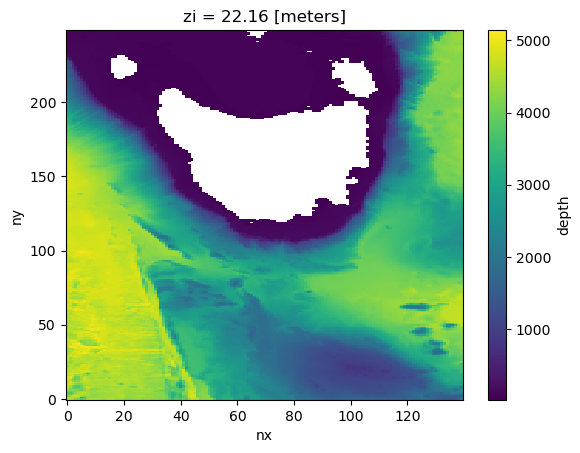

In [8]:
expt.topog.depth.plot()

##  Step 5: Handle the ocean forcing - where the magic happens

This cuts out and interpolates the initial condition as well as all boundaries (unless you don't pass it boundaries).

The dictionary maps the MOM6 variable names to what they're called in your ocean input file. Notice how for GLORYs, the horizontal dimensions are x and y, vs xh, yh, xq, yq for ACCESS OM2-01. This is because for an 'A' grid type tracers share the grid with velocities so there's no difference.

If one of your segments is land, you can delete its string from the 'boundaries' list. You'll need to update MOM_input to reflect this though so it knows how many segments to look for, and their orientations. 


In [ ]:
expt.ocean_forcing(
    glorys_path,  ## Path to ocean foring files
    {"time":"time",
     "y":"latitude",
     "x":"longitude",
     "zl":"depth",
     "eta":"zos",
     "u":"uo",
     "v":"vo",
     "tracers":{"salt":"so",
                "temp":"thetao"
                }
    },
    boundaries = ["south","north","west","east"],
    gridtype="A"  ## Grid type. This is an Arakawa A grid sice velocities and tracers are all on the same points
)

## Step 6 Run the FRE tools

This is just a wrapper for the FRE tools needed to make the mosaics and masks for the experiment. The only thing you need to tell it is the processor layout. In this case we're saying that we want a 10 by 10 grid of 100 processors. 

In [ ]:
expt.FRE_tools((10,10))


# Step 7 Set up ERA5 forcing:
Here we assume you've already got ERA5 data stored somewhere on your system. 

For this example, we are forcing for the entire year of 2003 so we just generate a single forcing file with 2003's data.

Below is a table showing ERA5 characteristics and what needs to be done to sort it out
### Required ERA data:
Name | ERA filename | era variable name | Units
---|---|---|---
Surface Pressure | sp | sp | Pa 
Surface Temperature | 2t | t2m | K 
Meridional Wind | 10v | v10 | m/s 
Zonal Wind | 10u | u10 | m/s 
Specific Humidity | na | na | kg/kg, calculated from dewpoint temperature
Dewpoint Temperature | 2d | d2m | K


We can calculate specific humidity $q$ from dewpoint temperature $T_d$ and surface pressure $P$ via saturation vapour pressure $P_v$.

$\large P_v = 10^{8.07131 - \frac{1730.63}{233.426 + T}} \frac{101325}{760} $ Pascals

$\large q = 0.001 * 0.622  \frac{P_v}{P}$ 

In [ ]:
erapath = "/g/data/rt52/era5/single-levels/reanalysis"

## Firstly just open all raw data
rawdata = {}
for fname , vname in zip(["2t","10u","10v","sp","2d"] , ["t2m","u10","v10","sp","d2m"]):

    ## Cut out this variable to our domain size
    rawdata[fname] = rm.nicer_slicer(
        xr.open_mfdataset(f"{erapath}/{fname}/{daterange[0].split('-')[0]}/{fname}*",decode_times = False,chunks = {"longitude":100,"latitude":100}),
        xextent,
        "longitude"
    ).sel(
        latitude = slice(yextent[1],yextent[0]) ## This is because ERA5 has latitude in decreasing order (??)
    )

    ## Now fix up the latitude and time dimensions

    rawdata[fname] = rawdata[fname].isel(
        latitude = slice(None,None,-1) ## Flip latitude        
        ).assign_coords(
        time = np.arange(0,rawdata[fname].time.shape[0],dtype=float) ## Set the zero date of forcing to start of run
        )
       

    rawdata[fname].time.attrs = {"calendar":"julian","units":f"hours since {daterange[0]}"} ## Fix up calendar to match

    if fname == "2d":
        ## Calculate specific humidity from dewpoint temperature 
        q = xr.Dataset(
            data_vars= {
                "q": (0.622 / rawdata["sp"]["sp"]) * (10**(8.07131 - 1730.63 / (233.426 + rawdata["2d"]["d2m"] - 273.15) )) * 101325 / 760
                }

        )
        q.q.attrs = {"long_name":"Specific Humidity","units": "kg/kg"}
        q.to_netcdf(f"{inputdir}/forcing/q_ERA5",unlimited_dims = "time",encoding = {"q":{"dtype":"double"}})
    else:
        rawdata[fname].to_netcdf(f"{inputdir}/forcing/{fname}_ERA5",unlimited_dims = "time",encoding = {vname:{"dtype":"double"}})


## Step 8: Modify the default input directory to make a (hopefully) runnable configuration out of the box

This cell just copies a default run directory and modifies it to match your configuration.



In [ ]:
## Copy the default directory to the run directory
shutil.copy("default_rundir/era5_surface/data_table", str(rundir))
## Make symlinks between run and input directories
os.symlink(str(inputdir), str(rundir / "inputdir"))
os.symlink(str(rundir), str(inputdir / "rundir"))

## we need some information from the hgrid file to make the mask table
hgrid = xr.open_dataset(f"{inputdir}/hgrid.nc")

## Get mask table information
ncpus = 10
mask_table = None
for i in os.listdir(f"{inputdir}"):
    if "mask_table" in i:
        mask_table = i
        a = mask_table.split(".")[1]
        b = mask_table.split(".")[2].split("x")
        ncpus = int(b[0]) * int(b[1]) - int(a)


## Modify MOM_input
inputfile = open(f"{rundir}/MOM_input",'r')
lines = inputfile.readlines()
inputfile.close()
for i in range(len(lines)):
    if "MASKTABLE" in lines[i]:
        if mask_table != None:
            lines[i] = f'MASKTABLE = "{mask_table}"\n'
        else:
            lines[i] = "# MASKTABLE = no mask table"
    if "LAYOUT =" in lines[i] and "IO" not in lines[i]:
        lines[i] = f'LAYOUT = {expt.layout[1]},{expt.layout[0]}\n'

    if "NIGLOBAL" in lines[i]: 
        # lines[i] = f"NIGLOBAL = {str(x_indices_centre[1] - x_indices_centre[0])}\n"
        lines[i] = f"NIGLOBAL = {hgrid.nx.shape[0]//2}\n"

        
    if "NJGLOBAL" in lines[i]:
        # lines[i] = f"NJGLOBAL = {str(y_indices_centre[1] - y_indices_centre[0])}\n"
        lines[i] = f"NJGLOBAL = {hgrid.ny.shape[0]//2}\n"

        
inputfile = open(f"{rundir}/MOM_input",'w')

inputfile.writelines(lines)
inputfile.close()

## Modify SIS_input
inputfile = open(f"{rundir}/SIS_input",'r')
lines = inputfile.readlines()
inputfile.close()
for i in range(len(lines)):
    if "MASKTABLE" in lines[i]:
        lines[i] = f'MASKTABLE = "{mask_table}"\n'
    if "NIGLOBAL" in lines[i]:
        # lines[i] = f"NIGLOBAL = {str(x_indices_centre[1] - x_indices_centre[0])}\n"
        lines[i] = f"NIGLOBAL = {hgrid.nx.shape[0]//2}\n"
    if "LAYOUT =" in lines[i] and "IO" not in lines[i]:
        lines[i] = f'LAYOUT = {expt.layout[1]},{expt.layout[0]}\n'
    if "NJGLOBAL" in lines[i]:
        # lines[i] = f"NJGLOBAL = {str(y_indices_centre[1] - y_indices_centre[0])}\n"
        lines[i] = f"NJGLOBAL = {hgrid.ny.shape[0]//2}\n"
        
inputfile = open(f"{rundir}/SIS_input",'w')
inputfile.writelines(lines)
inputfile.close()

## Modify config.yaml 
inputfile = open(f"{rundir}/config.yaml",'r')
lines = inputfile.readlines()
inputfile.close()
for i in range(len(lines)):
    if "ncpus" in lines[i]:
        lines[i] = f'ncpus: {str(ncpus)}\n'
    if "jobname" in lines[i]:
        lines[i] = f"jobname: mom6_{expt_name}\n"
        
    if "input:" in lines[i]:
        lines[i + 1] = f"    - {inputdir}\n"

inputfile = open(f"{rundir}/config.yaml",'w')
inputfile.writelines(lines)
inputfile.close()


# Modify input.nml 
inputfile = open(f"{rundir}/input.nml",'r')
lines = inputfile.readlines()
inputfile.close()
for i in range(len(lines)):
    if "current_date" in lines[i]:
        tmp = daterange[0].split(" ")[0].split("-")
        lines[i] = f"{lines[i].split(' = ')[0]} = {int(tmp[0])},{int(tmp[1])},{int(tmp[2])},0,0,0,\n"

 
inputfile = open(f"{rundir}/input.nml",'w')
inputfile.writelines(lines)
inputfile.close()
